In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcs
import pytorch_lightning as pl
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader

from torchmetrics import Accuracy

In [2]:
from torchinfo import summary


In [3]:
train_ds = torchvision.datasets.MNIST(root='~/Documents/Dissertation/torch_ds/', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
val_ds = torchvision.datasets.MNIST(root='~/Documents/Dissertation/torch_ds/', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_dl = DataLoader(train_ds, shuffle=True, batch_size=64, num_workers=4)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64, num_workers=4)

In [4]:
class SegImageDataset(Dataset):
    def __init__(self, base_ds):
        self.base_ds = base_ds

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        x, y = self.base_ds[idx]
        x_label = ((x > 0.1) * (y+1)).squeeze().type(torch.long)
        #x_label = ((x > 0.1)).squeeze().type(torch.int32)
        return x, x_label

In [5]:
train_ds_seg = SegImageDataset(train_ds)
val_ds_seg = SegImageDataset(val_ds)

train_dl_seg = DataLoader(train_ds_seg, shuffle=True, batch_size=128, num_workers=4)
val_dl_seg = DataLoader(val_ds_seg, shuffle=False, batch_size=64, num_workers=4)

In [6]:
batch = next(iter(val_dl))

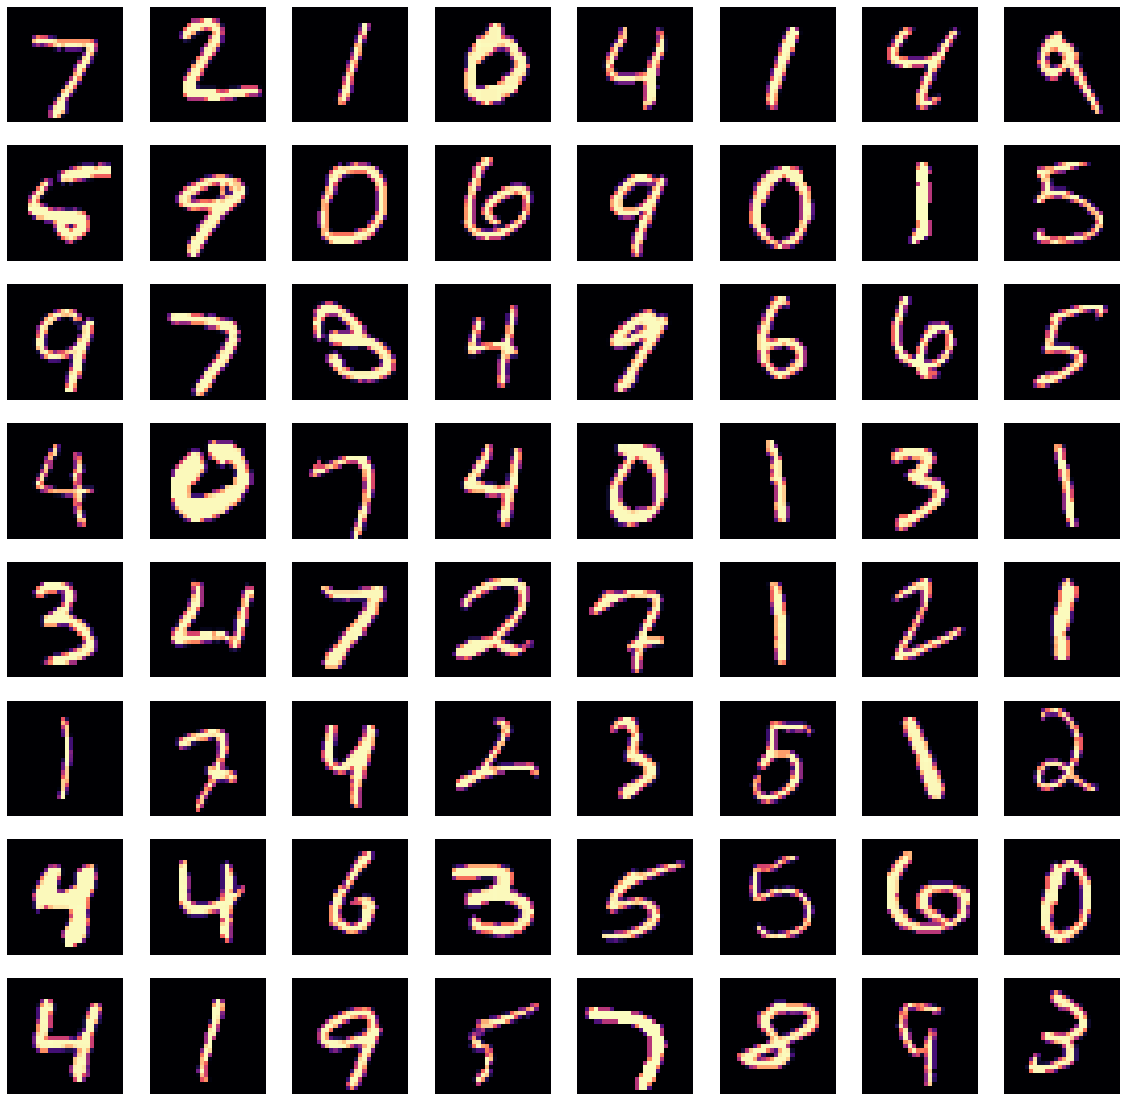

In [7]:
# pick a batch and show them
plt.figure(figsize=(20,20))
for i, (x, y) in enumerate(zip(batch[0], batch[1])):
    plt.subplot(8,8,i+1)
    plt.imshow(x[0], cmap='magma')
    plt.axis('off')

#plt.imshow(train_ds[0][0][0], cmap='magma'); plt.show()

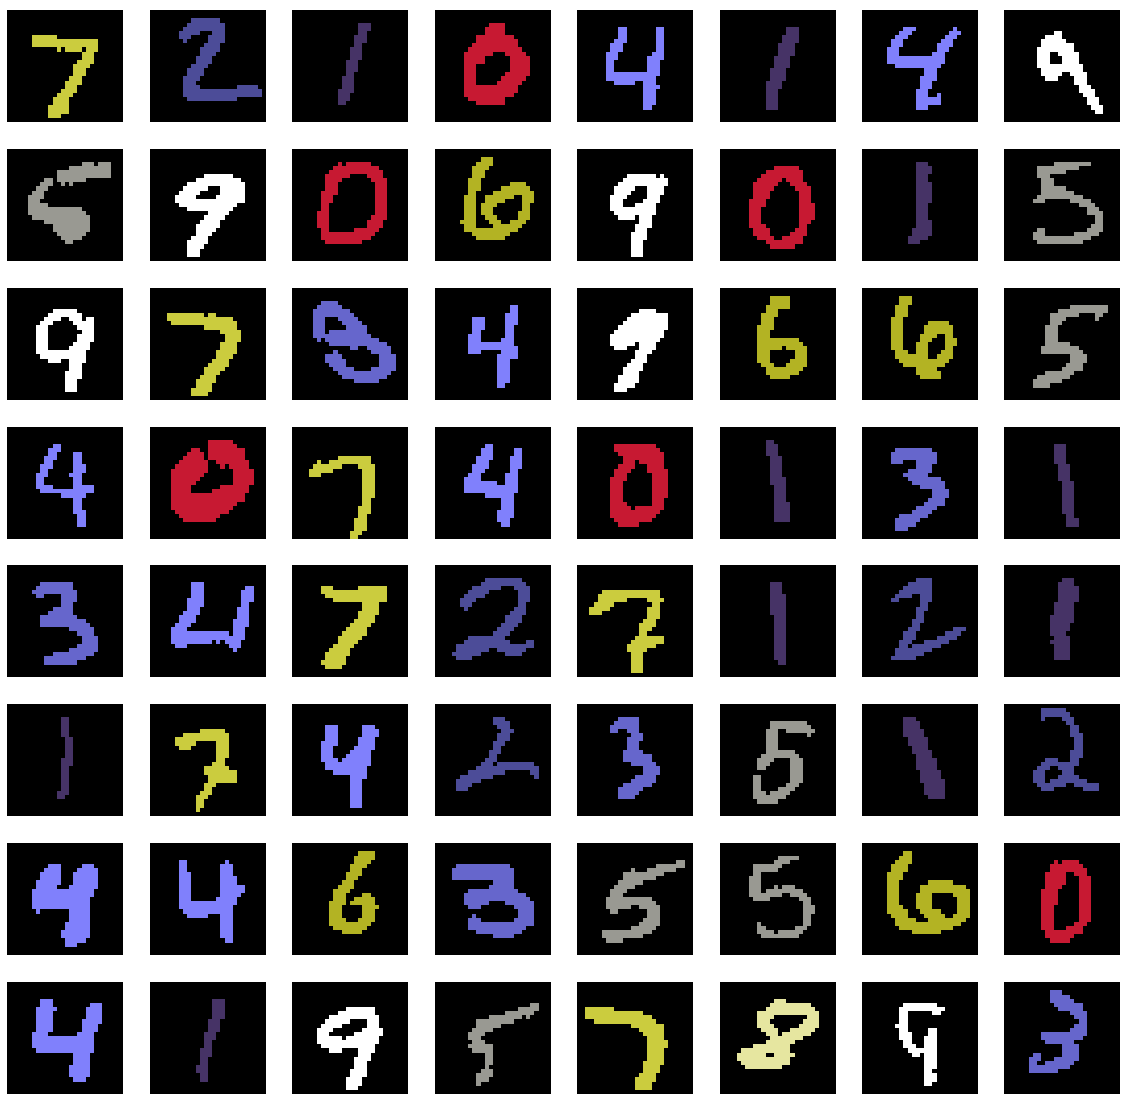

In [8]:
plt.figure(figsize=(20,20))
cmap = mcs.get_cmap('gist_stern')
for i, (x, y) in enumerate(zip(batch[0], batch[1])):
    plt.subplot(8,8,i+1)
    plt.imshow(cmap((x[0] >0.1) * (y+1) * (1/10)))
    plt.axis('off')

In [9]:
class GenericModel(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=10, nodes=64):
        super().__init__()
        self.accuracy = Accuracy()
        
    def forward(self, x):
        pass
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        p_hat = self(x)
        loss = torch.nn.functional.cross_entropy(p_hat, y, reduction='mean')
        self.log('train_loss', loss)
        self.accuracy(p_hat, y)
        self.log('train_acc_step', self.accuracy)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        p_hat = self(x)
        loss = torch.nn.functional.cross_entropy(p_hat, y, reduction='mean')
        self.log('val_loss', loss)
        self.accuracy(p_hat, y)
        self.log('val_acc_step', self.accuracy)
        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy)
        
    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy)
        
        
class ClassifyModel(GenericModel):
    def __init__(self, in_channels=1, out_channels=10, nodes=64):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels, nodes, 3)
        self.layer2 = nn.Conv2d(nodes, nodes, 3)
        self.layer3 = nn.Conv2d(nodes, nodes, 3)
        self.layer_dense = nn.Linear(nodes, out_channels)
        self.lrelu = nn.LeakyReLU(0.01)
        self.flatten = torch.nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        
        self.accuracy = Accuracy()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.lrelu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.layer2(x)
        x = self.lrelu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.layer3(x)
        x = self.lrelu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.flatten(x)
        x = self.layer_dense(x)
        x = self.softmax(x)
        return x
        
class SegModel(GenericModel):
    def __init__(self, in_channels=1, out_channels=11, nodes=64):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels, nodes, 3, padding='same')
        self.layer2 = nn.Conv2d(nodes, nodes, 3, padding='same')
        self.layer3 = nn.Conv2d(nodes, nodes, 3, padding='same')
        self.layer4 = nn.Conv2d(nodes, nodes, 3, padding='same')
        self.layer5 = nn.Conv2d(nodes, nodes, 3, padding='same')
        self.layer6 = nn.Conv2d(nodes, out_channels, 3, padding='same')
        self.lrelu = nn.LeakyReLU(0.01)
        self.flatten = None
        self.layer_dense = None
        self.softmax = nn.Softmax(dim=1)
        
        self.accuracy = Accuracy()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.lrelu(x)
        x = self.layer2(x)
        x = self.lrelu(x)
        x = self.layer3(x)
        x = self.lrelu(x)
        x = self.layer4(x)
        x = self.lrelu(x)
        x = self.layer5(x)
        x = self.lrelu(x)
        x = self.layer6(x)
        x = self.softmax(x)
        return x

In [10]:
model = SegModel()

In [11]:
summary(model, (1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
SegModel                                 --                        --
├─Accuracy: 1-1                          --                        --
├─Conv2d: 1-2                            --                        (recursive)
├─Conv2d: 1-3                            --                        (recursive)
├─Conv2d: 1-4                            --                        (recursive)
├─Conv2d: 1-5                            --                        (recursive)
├─Conv2d: 1-6                            --                        (recursive)
├─Conv2d: 1-7                            [1, 64, 28, 28]           640
├─LeakyReLU: 1-8                         [1, 64, 28, 28]           --
├─Conv2d: 1-9                            [1, 64, 28, 28]           36,928
├─LeakyReLU: 1-10                        [1, 64, 28, 28]           --
├─Conv2d: 1-11                           [1, 64, 28, 28]           36,928
├─LeakyReLU: 1-12              

In [12]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, train_dl_seg, val_dl_seg)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | accuracy | Accuracy  | 0     
1 | layer1   | Conv2d    | 640   
2 | layer2   | Conv2d    | 36.9 K
3 | layer3   | Conv2d    | 36.9 K
4 | layer4   | Conv2d    | 36.9 K
5 | layer5   | Conv2d    | 36.9 K
6 | layer6   | Conv2d    | 6.3 K 
7 | lrelu    | LeakyReLU | 0     
8 | softmax  | Softmax   | 0     
---------------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.619     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [14]:
trainer.validate(model, train_dl_seg)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/benp/anaconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     train_acc_epoch        0.8249630331993103
      val_acc_step          0.8249630331993103
        val_loss             1.717193603515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.717193603515625,
  'val_acc_step': 0.8249630331993103,
  'train_acc_epoch': 0.8249630331993103}]

In [15]:
batch = next(iter(train_dl_seg))

In [16]:
with torch.no_grad():
    p = model(batch[0].to(model.device)).cpu()

In [17]:
p.unique()

tensor([0.0000e+00, 1.4013e-45, 2.8026e-45, 1.0000e+00])

In [18]:
x.shape

torch.Size([1, 28, 28])

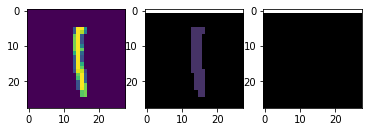

In [27]:
ind = 13
x = batch[0][ind]
y = batch[1][ind]
pred = p[ind].argmax(dim=0)
cmap = mcs.get_cmap('gist_stern')
plt.subplot(1,3,1)
plt.imshow(x.squeeze())
plt.subplot(1,3,2)
plt.imshow(cmap(y * (1/10)))
plt.subplot(1,3,3)
plt.imshow(cmap(pred * (1/10)))

In [207]:
y.unique()

tensor([0, 4])

In [123]:
p.argmax(dim=1).unique()

tensor([0])

In [169]:
torch.nn.functional.cross_entropy(p, batch[1])

tensor(2.3947)

In [138]:
p.shape, batch[1].shape

(torch.Size([64, 11, 28, 28]), torch.Size([64, 28, 28]))

In [215]:
answer = torch.zeros(p.shape)
for i in range(len(batch[1])):
    c = batch[1][i].unique()[1]
    answer[i][c][batch[1][i] == c] = 1
    answer[i][0][batch[1][i] != c] = 1

In [216]:
torch.nn.functional.cross_entropy(answer[0].unsqueeze(0), batch[1][0].unsqueeze(0))

tensor(1.5430)

In [155]:
torch.sum(answer.argmax(dim=1) - batch[1])

tensor(0)

In [147]:
batch[1][0].shape

torch.Size([28, 28])

In [192]:
answer[0].unsqueeze(0).shape

torch.Size([1, 11, 28, 28])

In [200]:
batch[1][0].shape

torch.Size([])

In [201]:
batch[1].shape

torch.Size([64])

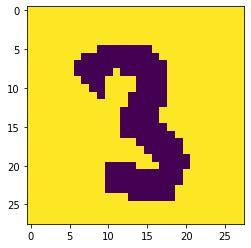

In [217]:
plt.imshow(answer[0][0])

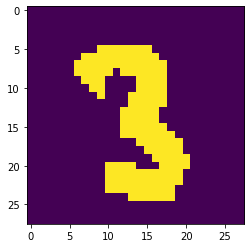

In [219]:
plt.imshow(answer[0][4])

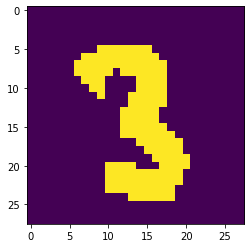

In [220]:
plt.imshow(batch[1][0])

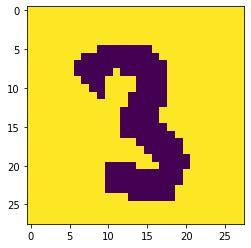

In [224]:
plt.imshow(answer[0][4] - batch[1][0])

In [225]:
answer[0][4] - batch[1][0]

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -3., -3., -3., -3., -3.,
         -3., -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -3

In [226]:
answer[0][4] 

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  

In [227]:
batch[1][0]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0